In [1]:
from model import *

In [4]:
batch_size = 20
mode1 = 5
mode2 = 5
width = 20
res_x = 8
res_y = 8
resolution =64
x = torch.ones(batch_size ,res_x, res_y,10)
model = FNO2d(mode1, mode2,  width,resolution)
a = model(x)

/opt/conda/envs/pytorch-py3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:417: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [22]:
import numpy as np
from numpy import sin,cos,pi,exp
import torch 
from model import Heat_forward
def ture_u(x,y,t):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.exp(-t)

def init_u(x,y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)

def source(x,y,t):
    k =1/16
    return (-1+k*8*np.pi**2)*np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.exp(-t)

n_x = 40
n_y = 40
domain = [0,1,0,1]
T = 1
n_t  = 100
x = np.linspace(domain[0],domain[1],n_x)
y = np.linspace(domain[2],domain[3],n_y)
t= np.linspace(0,T,n_t)
dx = (domain[1] - domain[0])/n_x
dy = (domain[3] - domain[2])/n_y
dt = T/n_t
alpha = 1/16
r = alpha*dt/dx/dx
fdm = Heat_forward(n_x =n_x,dt = dt , alpha = alpha)


U = torch.Tensor(np.zeros((len(x),len(y),len(t),1)))

node = (len(x))*(len(y))   #自由度个数


#定义初值
X,Y = np.meshgrid(x,y)

U[:,:,0,0] = torch.Tensor(init_u(X,Y))


time = 0

for i in range(n_t-1):
    time = time+dt
    f_old = torch.Tensor(source(X,Y,time-dt)).unsqueeze(-1)
    f_new = torch.Tensor(source(X,Y,time)).unsqueeze(-1)
    input = torch.cat((U[:,:,i,:],f_old,f_new),2)
    U[:,:,i+1,0] = fdm(input)
#print(U[:,:,-1])
TURE_U = ture_u(X,Y,1)   #t =1 时刻真解





/tmp/ipykernel_24750/2204919002.py:70: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax3d = Axes3D(fig)
/tmp/ipykernel_24750/2204919002.py:74: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax3d = Axes3D(fig)


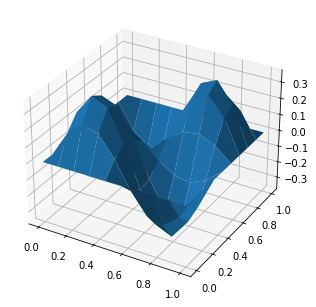

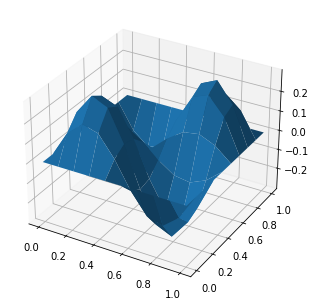

In [18]:
import numpy as np
from numpy import sin,cos,pi,exp


def ture_u(x,y,t):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.exp(-t)

def init_u(x,y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
def source(x,y,t):
    k =1/16
    return (-1+k*8*np.pi**2)*np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.exp(-t)

n_x = 10
n_y = 10
domain = [0,1,0,1]
T = 1
n_t  = 100
x = np.linspace(domain[0],domain[1],n_x)
y = np.linspace(domain[2],domain[3],n_y)
t= np.linspace(0,T,n_t)
dx = (domain[1] - domain[0])/n_x
dy = (domain[3] - domain[2])/n_y
dt = T/n_t
alpha = 1/16
r = alpha*dt/dx/dx

U = np.zeros((len(x),len(y),len(t)))
node = (len(x))*(len(y))   #自由度个数

d1 = np.ones((node,))*(-2*r+1)
d2 = np.ones((node,))*(2*r+1)

d3 = np.ones((node - 1,))*(r/2)
d4 = np.ones((node - len(x),))*(r/2)

A1 = np.diag(d2) - np.diag(d3,-1) - np.diag(d3,1) - np.diag(d4,- len(x)) - np.diag(d4, len(x))
A0 =  np.diag(d1) + np.diag(d3,-1) + np.diag(d3,1) + np.diag(d4,- len(x)) + np.diag(d4, len(x))


#定义初值
X,Y = np.meshgrid(x,y)
U[:,:,0] = init_u(X,Y)


time = 0

for i in range(n_t-1):
    time = time+dt
    U_NEW = U[:,:,i].reshape(-1)   #展开为一个一维的向量
    f_old = source(X,Y,time-dt).reshape(-1)
    f_new = source(X,Y,time).reshape(-1)
    b = A0@U_NEW + (f_old/2+f_new/2)*dt
    U_NEW = np.linalg.solve(A1,b)  
    U[:,:,i+1] = U_NEW.reshape(n_x,-1)   #再用reshape改变回来
    
    #强制改变边界条件
    U[:,-1,i+1] = 0
    U[:,0,i+1] = 0
    U[-1,:,i+1] = 0
    U[0,:,i+1] = 0
#print(U[:,:,-1])
TURE_U = ture_u(X,Y,time)   #t =1 时刻真解
#print(TURE_U)

import matplotlib.pyplot as plt
fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D

ax3d = Axes3D(fig)
ax3d.plot_surface(X,Y,TURE_U)

fig = plt.figure()
ax3d = Axes3D(fig)
ax3d.plot_surface(X,Y,U[:,:,-1])


/tmp/ipykernel_24750/3580838141.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax3d = Axes3D(fig)
/tmp/ipykernel_24750/3580838141.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax3d = Axes3D(fig)


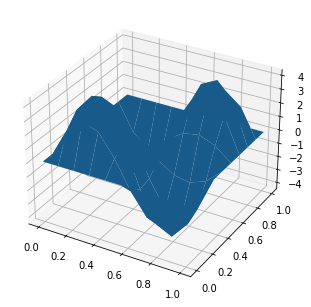

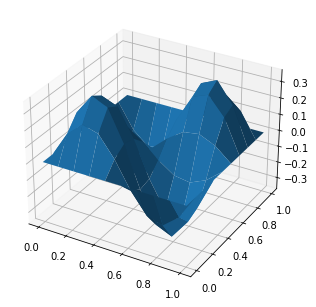

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax3d = Axes3D(fig)
ax3d.plot_surface(X,Y,U[:,:,-1])

fig = plt.figure()
ax3d = Axes3D(fig)
ax3d.plot_surface(X,Y,TURE_U)

In [2]:
from Buffer import ReplayBuffer
import torch


In [1]:
import gym
import Heat
from Buffer import ReplayBuffer
import torch
import numpy as np
obs_dim  =10
act_dim = 6
init_step = 100
buffer_init = ReplayBuffer( obs_dim = obs_dim, act_dim = act_dim, size = 500)
env = gym.make('Heat_d-v0')

for step in range(init_step):
    action = env.action_space.sample()   # 从动作空间中随机选取一个动作
    observation = torch.Tensor(env.get_value())
    observation1, reward, done, info = env.step(action)  # 用于提交动作，括号内是具体的动作
    observation1 = torch.Tensor(observation1)
    reward = torch.Tensor(np.array(reward))
    action1 = torch.Tensor(action)
    done1= torch.Tensor(np.array(done,dtype = np.float32))
    buffer_init.store(obs = observation , act = action1, rew = reward, next_obs = observation1,done = done1,store_size = 1)
    print(step)
    if done :
        env.reset()
env.close()

/opt/conda/envs/pytorch-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


num of vertices 1089
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
import torch
idxs = torch.randint(0, 200-4, size=(20,))
idx = idxs.clone()
n_step  = 4
idxs = idxs.unsqueeze(-1)
idx = idx.unsqueeze(-1)
for i in range(n_step-1):
        print(i)
        idxs = torch.cat((idxs,idx+i+1),dim = 1)
idx_obs = idxs.reshape(-1)
idx_act = idxs[:,:-1].reshape(-1)

0
1
2


In [2]:
idx_obs

tensor([ 28,  29,  30,  31, 174, 175, 176, 177,   4,   5,   6,   7,  52,  53,
         54,  55, 188, 189, 190, 191,  11,  12,  13,  14, 170, 171, 172, 173,
         99, 100, 101, 102, 124, 125, 126, 127,  62,  63,  64,  65, 185, 186,
        187, 188,  95,  96,  97,  98,  11,  12,  13,  14,  49,  50,  51,  52,
        101, 102, 103, 104, 179, 180, 181, 182, 144, 145, 146, 147,   3,   4,
          5,   6, 101, 102, 103, 104,  87,  88,  89,  90])

In [3]:
idx_act

tensor([ 28,  29,  30, 174, 175, 176,   4,   5,   6,  52,  53,  54, 188, 189,
        190,  11,  12,  13, 170, 171, 172,  99, 100, 101, 124, 125, 126,  62,
         63,  64, 185, 186, 187,  95,  96,  97,  11,  12,  13,  49,  50,  51,
        101, 102, 103, 179, 180, 181, 144, 145, 146,   3,   4,   5, 101, 102,
        103,  87,  88,  89])

tensor([[0.7366],
        [0.3379],
        [0.2140],
        [0.3379],
        [0.7366],
        [0.3379]])